<a href="https://colab.research.google.com/github/kamaldyaz/computer_vison/blob/main/Fine_tuning_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install openai-clip

In [2]:
pip install datasets

In [3]:
pip install torch

In [4]:
pip install tqdm

In [5]:
from datasets import load_dataset

ds = load_dataset('ceyda/fashion-products-small')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image'],
        num_rows: 42700
    })
})

In [7]:
entry = ds['train'][60]
entry

{'filename': '42841.jpg',
 'link': 'http://assets.myntassets.com/v1/images/style/properties/97d3bb4a71c9f7da88305ce9144d8576_images.jpg',
 'id': '42841',
 'masterCategory': 'Accessories',
 'gender': 'Women',
 'subCategory': 'Bags',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>}

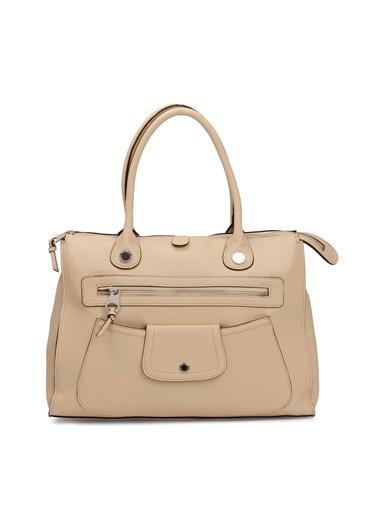

In [8]:
image = entry['image']
image

In [9]:
dataset = ds['train']

In [10]:
import clip
import torch

model, preprocess = clip.load("ViT-B/32", jit = False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

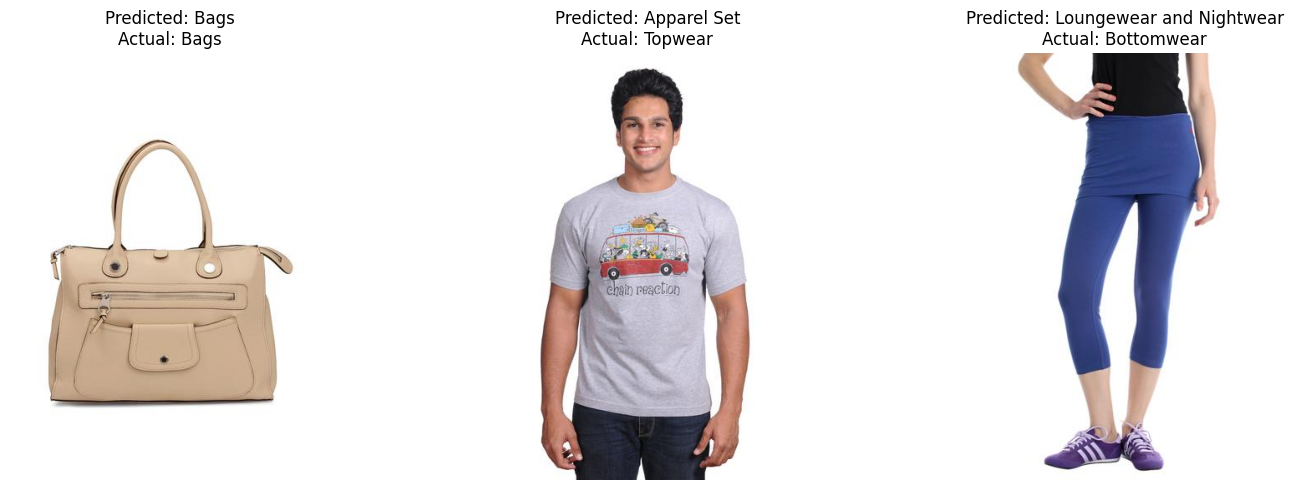

In [11]:
import matplotlib.pyplot as plt
indices = [60, 5, 95]
subcategories = list(set(example['subCategory'] for example in dataset))
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in subcategories]).to(device)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
for i, idx in enumerate(indices):
    example = dataset[idx]
    image = example['image']
    subcategory = example['subCategory']
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim = -1, keepdim = True)
    text_features /= text_features.norm(dim = -1, keepdim = True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim = -1)
    values, indices = similarity[0].topk(1)
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[indices[0]]}\nActual: {subcategory}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


In [12]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
from torchvision import transforms
from torch.utils.data import Dataset
class FashionDataset(Dataset) :
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        subcategory = item['subCategory']
        label = subcategories.index(subcategory)

        return self.transform(image), label

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(FashionDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(FashionDataset(val_dataset), batch_size=32, shuffle = False)


In [15]:
import torch.nn as nn
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)
    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()
        return self.classifier(features)


In [16]:
num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)


In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr =1e-4)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
from tqdm import tqdm
num_epochs = 5
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch (epoch+1)/{num_epochs}, Loss: 0.0000")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
    # validation
    model_ft.eval()
    correct =0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation accuracy: {100*correct/total}%')
torch.save(model_ft.state_dict(), '//content/drive/MyDrive/Fine_Tuning/CLIP/clip_finetuned.pth')

Epoch 1/5, Loss: 1.5299: 100%|██████████| 1068/1068 [03:28<00:00,  5.12it/s]


Epoch 1/5, Loss: 1.5299
Validation accuracy: 84.98829039812647%


Epoch 2/5, Loss: 0.5718: 100%|██████████| 1068/1068 [03:18<00:00,  5.37it/s]


Epoch 2/5, Loss: 0.5718
Validation accuracy: 90.19906323185012%


Epoch 3/5, Loss: 0.3791: 100%|██████████| 1068/1068 [03:19<00:00,  5.36it/s]


Epoch 3/5, Loss: 0.3791
Validation accuracy: 91.95550351288057%


Epoch 4/5, Loss: 0.2989: 100%|██████████| 1068/1068 [03:22<00:00,  5.29it/s]


Epoch 4/5, Loss: 0.2989
Validation accuracy: 92.65807962529274%


Epoch 5/5, Loss: 0.2555: 100%|██████████| 1068/1068 [03:22<00:00,  5.27it/s]


Epoch 5/5, Loss: 0.2555
Validation accuracy: 93.33723653395785%


<ipython-input-25-d351f826ef77>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('//content/drive/MyDrive/Fine_Tuning/CLIP/clip_finetuned

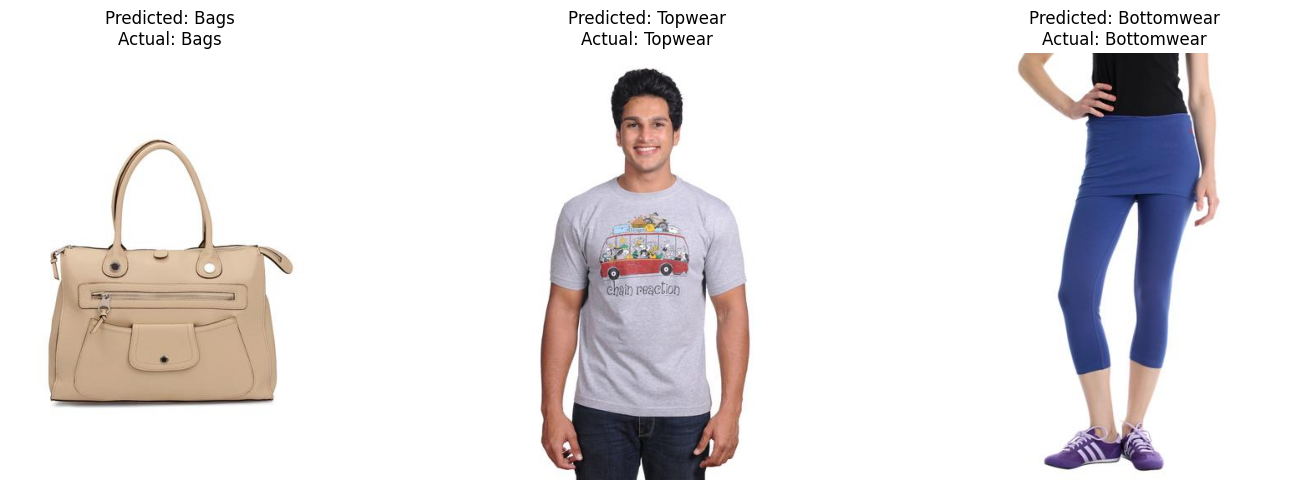

In [25]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
model_ft.load_state_dict(torch.load('//content/drive/MyDrive/Fine_Tuning/CLIP/clip_finetuned.pth'))
model_ft.eval()
indices = [60, 5, 95]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
for i, idx in enumerate(indices):
    example = dataset[idx]
    image = example['image']
    subcategory = example['subCategory']
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]


    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {predicted_label}\nActual: {subcategory}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()